## Seq_Data Clustering in PNAS 2015 - Early signaling dynamics of the EGFR

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
from msresist.clustering import MassSpecClustering
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.FileExporter import create_download_link


import warnings
warnings.simplefilter("ignore")

### Make MS Data Compatible

In [2]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 1000)

fulldata = pd.read_csv("msresist/data/Raw/pnas.forestEGF.sd01.csv", header=0).iloc[:, :14].sort_values(by="Protein")
print("number of different peptides captured in this data set: ", fulldata.drop_duplicates(["Protein", "Sequence"]).shape[0])
#Format Name
names = FormatName(fulldata)
fulldata["Protein"] = names
names = []
list(map(lambda v: names.append(v.split(" [H")[0]), fulldata.iloc[:, 0]))
fulldata["Protein"] = names
names = []
list(map(lambda v: names.append(v.split(" isoform")[0]), fulldata.iloc[:, 0]))
fulldata["Protein"] = names

#Format Seqs and map to proteome to obtain motifs
fulldata["Sequence"] = [seq.replace("(pY)", "y") for seq in list(fulldata.iloc[:, 1])]
fulldata["Sequence"] = [seq.replace("(pS)", "s") for seq in list(fulldata.iloc[:, 1])]
fulldata["Sequence"] = [seq.replace("(pT)", "t") for seq in list(fulldata.iloc[:, 1])]
fulldata["Sequence"] = [seq.replace("(M)", "M") for seq in list(fulldata.iloc[:, 1])]
fulldata = pYmotifs(fulldata, names)
fulldata = preprocess_seqs(fulldata, "Y")

number of different peptides captured in this data set:  463


Split data by treatment conditions:

In [3]:
E100 = fulldata[fulldata["Condition"].str.contains("EGF 100 nM")]
E20 = fulldata[fulldata["Condition"].str.contains("EGF 20 nM") & ~fulldata["Condition"].str.contains("Na3VO4") & ~fulldata["Condition"].str.contains("dasatinib")]
E20_Na3VO4 = fulldata[fulldata["Condition"].str.contains("Na3VO4")]
E20_dasatinib = fulldata[fulldata["Condition"].str.contains("dasatinib")]
E10 = fulldata[fulldata["Condition"].str.contains("EGF 10 nM")]
E5 = fulldata[fulldata["Condition"].str.contains("EGF 5 nM")]
E2_5 = fulldata[fulldata["Condition"].str.contains("EGF 2.5 nM")]
E1 = fulldata[fulldata["Condition"].str.contains("EGF 1 nM")]
E0_4 = fulldata[fulldata["Condition"].str.contains("EGF 0.4 nM")]

Checked if it's worth concatenating, take integral, and frame data set with conditions as features. However, it seems that the number of overlapping peptides is fairly small.

In [4]:
E1020100 = pd.concat([E10, E20, E100])

dups = pd.DataFrame(pd.pivot_table(E1020100, index=["Protein", "Sequence"], aggfunc="size")).reset_index()
dups.columns = ["Protein", "Sequence", "Reps"]
print("overlapping peptides across conditions Erl 10nM, 20nM, 100nM :", dups[dups["Reps"] ==  3].shape[0])

overlapping peptides across conditions Erl 10nM, 20nM, 100nM : 63


### Run Clustering

In [5]:
ncl = 7
GMMweight = 0

#Not being used here, needed for any sklearn-compatible estimator
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]


def plotclustermeans(centers, ncl):
    colors_ = cm.rainbow(np.linspace(0, 1, ncl))

    centers = centers.T

    for i in range(centers.shape[0]):
        ax.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    ax.legend()

    ax.set_xticks(np.arange(centers.shape[1]))
    ax.set_xticklabels(E1020100.columns[5:], rotation=70, rotation_mode="anchor")
    ax.set_ylabel("normalized signal")

As in the SOM clustering they generated, we concatenate E10, E20, and E100 data sets and run the model

In [6]:
data = E1020100.iloc[:, 5:].T 
info = E1020100.iloc[:, :5]

Frist by looking at the sequences only:

#### PAM250

In [7]:
MSC_PAM = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="PAM250").fit(data, Y_cv)

0
1
2
3
4
5
6
7
convergence has been reached at iteration 7


In [8]:
E1020100_PAM = E1020100.assign(Cluster=[lab+1 for lab in list(MSC_PAM.labels_)])
E1020100_PAM[E1020100_PAM["Protein"].str.contains("Epidermal growth factor receptor")].sort_values(by="Sequence")

,Protein,Sequence,Condition,Position,BioReps,0s,10s,20s,30s,40s,50s,60s,70s,80s,Cluster
448,Epidermal growth factor receptor,AENAEyLRVAP,EGF 10 nM,Y1197-p,3,0.022265,0.25684,0.29291,0.60875,0.64395,0.70952,0.81356,0.78021,1.07160,7
449,Epidermal growth factor receptor,AENAEyLRVAP,EGF 100 nM,Y1197-p,3,0.028468,0.47494,0.88448,0.88706,0.76070,0.71637,0.75840,0.77722,0.96055,7
451,Epidermal growth factor receptor,AENAEyLRVAP,EGF 20 nM,Y1197-p,3,0.016375,0.44252,0.60532,0.61964,0.69079,0.80663,0.82686,0.88925,0.92430,7
528,Epidermal growth factor receptor substrate 15,ANFSAyPSEED,EGF 10 nM,Y849-p,3,0.048901,0.11200,0.20959,0.24469,0.42103,0.68637,0.81495,1.32240,1.19770,6
441,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 20 nM,Y1172-p,3,0.049061,0.42999,0.31044,0.57841,0.70229,0.85916,0.76802,0.89607,0.90925,3
438,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 10 nM,Y1172-p,3,0.062655,0.28720,0.37602,0.66722,0.71949,0.70297,0.77919,0.75463,1.04510,3
439,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 100 nM,Y1172-p,3,0.037179,0.49476,0.92378,0.92226,0.77096,0.76776,0.75425,0.72710,0.90885,3
464,Epidermal growth factor receptor,LPVPEyINQSV,EGF 20 nM,Y1092-p,2,0.122350,0.55876,0.64893,0.64876,0.77934,0.77807,0.84563,0.86994,0.82918,6
462,Epidermal growth factor receptor,LPVPEyINQSV,EGF 100 nM,Y1092-p,3,0.069425,0.65206,0.84368,0.78086,0.67607,0.68726,0.67866,0.78641,0.91290,6
461,Epidermal growth factor receptor,LPVPEyINQSV,EGF 10 nM,Y1092-p,3,0.074811,0.34431,0.44630,0.66382,0.72987,0.67122,0.76250,0.69868,1.01070,6


In [9]:
MSC_PAM.clustermembers(E1020100.T)

,Cluster_1,seqs_Cluster_1,UniprotAcc_Cluster_1,pos_Cluster_1,r2/Std_Cluster_1,BioReps_Cluster_1,Cluster_2,seqs_Cluster_2,UniprotAcc_Cluster_2,pos_Cluster_2,r2/Std_Cluster_2,BioReps_Cluster_2,Cluster_3,seqs_Cluster_3,UniprotAcc_Cluster_3,pos_Cluster_3,r2/Std_Cluster_3,BioReps_Cluster_3,Cluster_4,seqs_Cluster_4,UniprotAcc_Cluster_4,pos_Cluster_4,r2/Std_Cluster_4,BioReps_Cluster_4,Cluster_5,seqs_Cluster_5,UniprotAcc_Cluster_5,pos_Cluster_5,r2/Std_Cluster_5,BioReps_Cluster_5,Cluster_6,seqs_Cluster_6,UniprotAcc_Cluster_6,pos_Cluster_6,r2/Std_Cluster_6,BioReps_Cluster_6,Cluster_7,seqs_Cluster_7,UniprotAcc_Cluster_7,pos_Cluster_7,r2/Std_Cluster_7,BioReps_Cluster_7
0,"1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1",SFESRyQQPFE,EGF 10 nM,Y1253-p,3.0,0.108330,E3 ubiquitin-protein ligase CBL-B,PDLSIyLKGDV,EGF 10 nM,Y763-p,2.0,0.166360,"1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1",TAEPDyGALYE,EGF 10 nM,Y771-p,3.0,0.271170,SHC-transforming protein 1,FDDPSyVNVQN,EGF 10 nM,Y427-p,3.0,0.034980,"1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1",DYGALyEGRNP,EGF 10 nM,Y775-p,3.0,0.343060,Guanine nucleotide exchange factor VAV2,WFPSTyVEEEG,EGF 10 nM,Y871-p,3.0,0.419490,Caskin-2,NIRNTyNQTAL,EGF 10 nM,Y253-p,2,0.578110
1,Dedicator of cytokinesis protein 9,GIASPyTTSTP,EGF 10 nM,Y1237-p,2.0,0.247500,GRB2-associated-binding protein 1,SSQDCyDIPRA,EGF 10 nM,Y406-p,3.0,0.053138,PDZ domain-containing protein 11,IPYDDyPVVFL,EGF 10 nM,Y10-p,2.0,0.157910,SHC-transforming protein 1,FDDPSyVNVQN,EGF 10 nM,Y427-p,2.0,0.194810,"1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1",RNPGFyVEANP,EGF 10 nM,Y783-p,2.0,0.120760,OTU domain-containing protein 7B,SYSNGyREPPE,EGF 10 nM,Y779-p,3.0,0.149540,E3 ubiquitin-protein ligase CBL-B,RTPSDyDLLIP,EGF 10 nM,Y802-p,3,0.251920
2,E3 ubiquitin-protein ligase CBL,APSPNyDDDDD,EGF 10 nM,Y455-p,2.0,0.065701,GRB2-associated-binding protein 1,SSQDCyDIPRA,EGF 10 nM,Y406-p,2.0,0.063617,SH2 domain-containing adapter protein B,RPADEyDQPWE,EGF 10 nM,Y336-p,2.0,0.147420,Afadin,TYTREyFTFPA,EGF 10 nM,Y1230-p,3.0,0.368510,GRB2-associated-binding protein 1,VDSSLyNLPRS,EGF 10 nM,Y259-p,3.0,0.336200,Catenin delta-1,HYEDGyPGGSD,EGF 10 nM,Y221-p,2.0,0.268450,GRB2-associated-binding protein 1,DERVDyVVVDQ,EGF 10 nM,Y659-p,3,0.111990
3,E3 ubiquitin-protein ligase CBL,PPDRPySVGAE,EGF 10 nM,Y552-p,2.0,0.269600,Breast cancer anti-estrogen resistance protein 1,PEQDEyDIPRH,EGF 10 nM,Y234-p,3.0,1.013500,Ankyrin repeat and SAM domain-containing protein 1A,EDEHPyELLLT,EGF 10 nM,Y455-p,3.0,0.239740,Catenin delta-1,FHPEPyGLEDD,EGF 10 nM,Y280-p,2.0,0.308930,Breast cancer anti-estrogen resistance protein 1,GPQDIyDVPPV,EGF 10 nM,Y249-p,2.0,0.572800,Ephrin type-A receptor 2,KPLKTyVDPHT,EGF 10 nM,Y588-p,2.0,0.651050,GRB2-associated-binding protein 1,DKQVEyLDLDL,EGF 10 nM,Y627-p,3,0.058605
4,GRB2-associated-binding protein 1,DTDSSyCIPTA,EGF 10 nM,Y373-p,2.0,0.245830,Glycogen synthase kinase-3 alpha,EPNVSyICSRY,EGF 10 nM,Y279-p,3.0,0.843630,"Arf-GAP with Rho-GAP domain, ANK repeat and PH domain-containing protein 1",FDDsDyDEVPE,EGF 10 nM,Y231-p,3.0,0.343110,Caveolin-1,MSGGKyVDSEG,EGF 10 nM,Y6-p,2.0,0.645000,Caveolin-1,SEGHLyTVPIR,EGF 10 nM,Y14-p,3.0,0.781830,Epidermal growth factor receptor,SFLQRySSDPT,EGF 10 nM,Y1069-p,3.0,0.096296,GRB2-associated-binding protein 1,DERVDyVVVDQ,EGF 10 nM,Y659-p,3,0.057958
5,MARVEL domain-containing protein 2,PSDLPyQDTTI,EGF 10 nM,Y23-p,2.0,0.543610,Homeodomain-interacting protein kinase 3,TVCSTyLQSRY,EGF 10 nM,Y359-p,2.0,0.856030,"Arf-GAP with Rho-GAP domain, ANK repeat and PH domain-containing protein 1",FDDSDyDEVPE,EGF 10 nM,Y231-p,2.0,0.367010,Desmoglein-2,LVDQPyANEGT,EGF 10 nM,Y979-p,3.0,0.223780,Crk-like protein,YVRTLyDFPGN,EGF 10 nM,Y132-p,3.0,0.636560,Epidermal growth factor receptor,SFLQRySSDPT,EGF 10 nM,Y1069-p,3.0,0.064669,GRB2-associated-binding protein 1,DKQVEyLDLDL,EGF 10 nM,Y627-p,3,0.022278
6,SH2 domain-containing adapter protein B,TIADDySDPFD,E

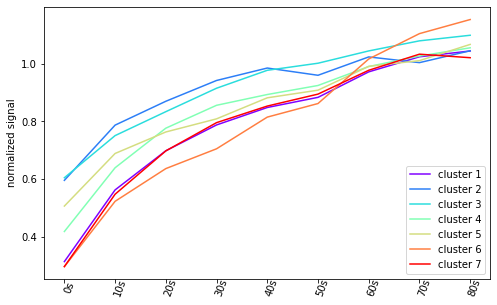

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
centers_PAM = MSC_PAM.transform(data)
plotclustermeans(centers_PAM, ncl)

Including data:

In [11]:
GMMweight = 2.5

MSC_PAM25 = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="PAM250").fit(data, Y_cv)
centers_PAM25 = MSC_PAM25.transform(data)

E1020100_PAM25 = E1020100.assign(Cluster=[lab+1 for lab in list(MSC_PAM25.labels_)])
E1020100_PAM25[E1020100_PAM25["Protein"].str.contains("Epidermal growth factor receptor")].sort_values(by="Sequence")

0
1
2
convergence has been reached at iteration 2


,Protein,Sequence,Condition,Position,BioReps,0s,10s,20s,30s,40s,50s,60s,70s,80s,Cluster
448,Epidermal growth factor receptor,AENAEyLRVAP,EGF 10 nM,Y1197-p,3,0.022265,0.25684,0.29291,0.60875,0.64395,0.70952,0.81356,0.78021,1.07160,4
449,Epidermal growth factor receptor,AENAEyLRVAP,EGF 100 nM,Y1197-p,3,0.028468,0.47494,0.88448,0.88706,0.76070,0.71637,0.75840,0.77722,0.96055,4
451,Epidermal growth factor receptor,AENAEyLRVAP,EGF 20 nM,Y1197-p,3,0.016375,0.44252,0.60532,0.61964,0.69079,0.80663,0.82686,0.88925,0.92430,4
528,Epidermal growth factor receptor substrate 15,ANFSAyPSEED,EGF 10 nM,Y849-p,3,0.048901,0.11200,0.20959,0.24469,0.42103,0.68637,0.81495,1.32240,1.19770,5
441,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 20 nM,Y1172-p,3,0.049061,0.42999,0.31044,0.57841,0.70229,0.85916,0.76802,0.89607,0.90925,4
438,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 10 nM,Y1172-p,3,0.062655,0.28720,0.37602,0.66722,0.71949,0.70297,0.77919,0.75463,1.04510,4
439,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 100 nM,Y1172-p,3,0.037179,0.49476,0.92378,0.92226,0.77096,0.76776,0.75425,0.72710,0.90885,4
464,Epidermal growth factor receptor,LPVPEyINQSV,EGF 20 nM,Y1092-p,2,0.122350,0.55876,0.64893,0.64876,0.77934,0.77807,0.84563,0.86994,0.82918,4
462,Epidermal growth factor receptor,LPVPEyINQSV,EGF 100 nM,Y1092-p,3,0.069425,0.65206,0.84368,0.78086,0.67607,0.68726,0.67866,0.78641,0.91290,4
461,Epidermal growth factor receptor,LPVPEyINQSV,EGF 10 nM,Y1092-p,3,0.074811,0.34431,0.44630,0.66382,0.72987,0.67122,0.76250,0.69868,1.01070,4


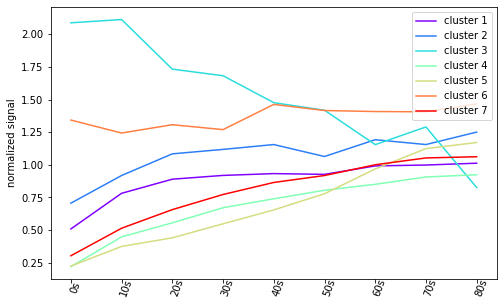

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclustermeans(centers_PAM25, ncl)

In [13]:
MSC_PAM25.clustermembers(E1020100_PAM25.T)

,Cluster_1,seqs_Cluster_1,UniprotAcc_Cluster_1,pos_Cluster_1,r2/Std_Cluster_1,BioReps_Cluster_1,Cluster_2,seqs_Cluster_2,UniprotAcc_Cluster_2,pos_Cluster_2,r2/Std_Cluster_2,BioReps_Cluster_2,Cluster_3,seqs_Cluster_3,UniprotAcc_Cluster_3,pos_Cluster_3,r2/Std_Cluster_3,BioReps_Cluster_3,Cluster_4,seqs_Cluster_4,UniprotAcc_Cluster_4,pos_Cluster_4,r2/Std_Cluster_4,BioReps_Cluster_4,Cluster_5,seqs_Cluster_5,UniprotAcc_Cluster_5,pos_Cluster_5,r2/Std_Cluster_5,BioReps_Cluster_5,Cluster_6,seqs_Cluster_6,UniprotAcc_Cluster_6,pos_Cluster_6,r2/Std_Cluster_6,BioReps_Cluster_6,Cluster_7,seqs_Cluster_7,UniprotAcc_Cluster_7,pos_Cluster_7,r2/Std_Cluster_7,BioReps_Cluster_7
0,Dedicator of cytokinesis protein 9,GIASPyTTSTP,EGF 10 nM,Y1237-p,2.0,0.247500,SHC-transforming protein 1,FDDPSyVNVQN,EGF 10 nM,Y427-p,2.0,0.194810,Sodium/potassium-transporting ATPase subunit alpha-1,RGIVVyTGDRT,EGF 10 nM,Y260-p,3.0,1.5480,"1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1",DYGALyEGRNP,EGF 10 nM,Y775-p,3.0,0.343060,"1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1",RNPGFyVEANP,EGF 10 nM,Y783-p,2.0,0.120760,"1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1",TAEPDyGALYE,EGF 10 nM,Y771-p,3.0,0.27117,E3 ubiquitin-protein ligase CBL,PPDRPySVGAE,EGF 10 nM,Y552-p,2,0.269600
1,E3 ubiquitin-protein ligase CBL-B,RTPSDyDLLIP,EGF 10 nM,Y802-p,3.0,0.251920,Annexin A2,GSVIDyELIDQ,EGF 10 nM,Y188-p,2.0,0.615960,Sodium/potassium-transporting ATPase subunit alpha-1,RGIVVyTGDRT,EGF 20 nM,Y260-p,3.0,3.1169,"1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1",SFESRyQQPFE,EGF 10 nM,Y1253-p,3.0,0.108330,Caskin-2,NIRNTyNQTAL,EGF 10 nM,Y253-p,2.0,0.578110,Cyclin-dependent kinase 1,IGEGTyGVVYK,EGF 10 nM,Y15-p,3.0,1.24140,E3 ubiquitin-protein ligase CBL-B,PDLSIyLKGDV,EGF 10 nM,Y763-p,2,0.166360
2,Alpha-enolase,ASTGIyEALEL,EGF 10 nM,Y44-p,3.0,0.689750,Annexin A2,GSVIDyELIDQ,EGF 10 nM,Y188-p,3.0,0.532380,Sodium/potassium-transporting ATPase subunit alpha-1,RGIVVyTGDRT,EGF 100 nM,Y260-p,3.0,1.5985,E3 ubiquitin-protein ligase CBL,APSPNyDDDDD,EGF 10 nM,Y455-p,2.0,0.065701,GRB2-associated-binding protein 1,DTDSSyCIPTA,EGF 10 nM,Y373-p,2.0,0.245830,Cyclin-dependent kinase 1,IGEGTyGVVYK,EGF 10 nM,Y15-p,3.0,1.19810,GRB2-associated-binding protein 1,SSQDCyDIPRA,EGF 10 nM,Y406-p,3,0.053138
3,Putative annexin A2-like protein,TPPSAyGSVKA,EGF 10 nM,Y24-p,2.0,0.837780,Breakpoint cluster region protein,GVDGDyEDAEL,EGF 10 nM,Y246-p,2.0,0.557410,NaN,NaN,NaN,NaN,NaN,NaN,GRB2-associated-binding protein 1,DERVDyVVVDQ,EGF 10 nM,Y659-p,3.0,0.111990,OTU domain-containing protein 7B,SYSNGyREPPE,EGF 10 nM,Y779-p,3.0,0.149540,Cyclin-dependent kinase 1,IGEGTyGVVYK,EGF 10 nM,Y15-p,2.0,1.50900,GRB2-associated-binding protein 1,SSQDCyDIPRA,EGF 10 nM,Y406-p,2,0.063617
4,"Arf-GAP with Rho-GAP domain, ANK repeat and PH domain-containing protein 1",FDDsDyDEVPE,EGF 10 nM,Y231-p,3.0,0.343110,Breast cancer anti-estrogen resistance protein 1,PEQDEyDIPRH,EGF 10 nM,Y234-p,3.0,1.013500,NaN,NaN,NaN,NaN,NaN,NaN,GRB2-associated-binding protein 1,DKQVEyLDLDL,EGF 10 nM,Y627-p,3.0,0.058605,TOM1-like protein 2,RKTVTyEDPQA,EGF 10 nM,Y404-p,2.0,0.325180,"1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1",TAEPDyGALYE,EGF 20 nM,Y771-p,3.0,0.26031,GRB2-associated-binding protein 1,VDSSLyNLPRS,EGF 10 nM,Y259-p,3,0.336200
5,Crk-like protein,YVRTLyDFPGN,EGF 10 nM,Y132-p,3.0,0.636560,Ephrin type-A receptor 2,SPEDVyFSKSE,EGF 10 nM,Y575-p,2.0,1.553100,NaN,NaN,NaN,NaN,NaN,NaN,GRB2-associated-binding protein 1,DERVDyVVVDQ,EGF 10 nM,Y659-p,3.0,0.057958,TOM1-like protein 2,RKTVTyEDPQA,EGF 10 nM,Y404-p,3.0,0.366320,Cyclin-dependent kinase 1,IGEGTyGVVYK,EGF 20 nM,Y15-p,3.0,1.25280,Guanine nucleotide exchange factor VAV2,WFPSTyVEEEG,EGF 10 nM,Y871-p,3,0.419490
6,Glycogen synthase kinase-3 alpha,EPNVSyICSRY,EGF 10 nM,Y279-p,3.0,0.843630,Filamin-B,IDNYDySHTVK,EGF 10 nM,Y904-p,3.0,0.955350,NaN,NaN,NaN,NaN,NaN,NaN,GRB2-associated-binding protein 1,DKQVEyLDLDL,EGF 10 nM,Y6

BINOMIAL:

In [14]:
GMMweight = 0

MSC_BPM = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="Binomial").fit(data, Y_cv)
centers_BPM = MSC_BPM.transform(data)

0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
1
Re-initialize GMM clusters, empty cluster(s) at iteration 1
2
3
4
5
6
7
8
9
10
11
12
13
convergence has been reached at iteration 13


In [15]:
E1020100_BPM = E1020100.assign(Cluster=[lab+1 for lab in list(MSC_BPM.labels_)])
E1020100_BPM[E1020100_BPM["Protein"].str.contains("Epidermal growth factor receptor")].sort_values(by="Sequence")

,Protein,Sequence,Condition,Position,BioReps,0s,10s,20s,30s,40s,50s,60s,70s,80s,Cluster
448,Epidermal growth factor receptor,AENAEyLRVAP,EGF 10 nM,Y1197-p,3,0.022265,0.25684,0.29291,0.60875,0.64395,0.70952,0.81356,0.78021,1.07160,4
449,Epidermal growth factor receptor,AENAEyLRVAP,EGF 100 nM,Y1197-p,3,0.028468,0.47494,0.88448,0.88706,0.76070,0.71637,0.75840,0.77722,0.96055,4
451,Epidermal growth factor receptor,AENAEyLRVAP,EGF 20 nM,Y1197-p,3,0.016375,0.44252,0.60532,0.61964,0.69079,0.80663,0.82686,0.88925,0.92430,4
528,Epidermal growth factor receptor substrate 15,ANFSAyPSEED,EGF 10 nM,Y849-p,3,0.048901,0.11200,0.20959,0.24469,0.42103,0.68637,0.81495,1.32240,1.19770,6
441,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 20 nM,Y1172-p,3,0.049061,0.42999,0.31044,0.57841,0.70229,0.85916,0.76802,0.89607,0.90925,3
438,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 10 nM,Y1172-p,3,0.062655,0.28720,0.37602,0.66722,0.71949,0.70297,0.77919,0.75463,1.04510,3
439,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 100 nM,Y1172-p,3,0.037179,0.49476,0.92378,0.92226,0.77096,0.76776,0.75425,0.72710,0.90885,3
464,Epidermal growth factor receptor,LPVPEyINQSV,EGF 20 nM,Y1092-p,2,0.122350,0.55876,0.64893,0.64876,0.77934,0.77807,0.84563,0.86994,0.82918,4
462,Epidermal growth factor receptor,LPVPEyINQSV,EGF 100 nM,Y1092-p,3,0.069425,0.65206,0.84368,0.78086,0.67607,0.68726,0.67866,0.78641,0.91290,4
461,Epidermal growth factor receptor,LPVPEyINQSV,EGF 10 nM,Y1092-p,3,0.074811,0.34431,0.44630,0.66382,0.72987,0.67122,0.76250,0.69868,1.01070,4


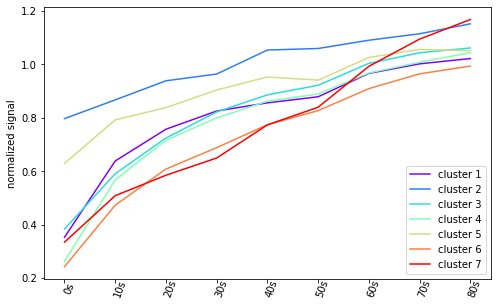

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclustermeans(centers_BPM, ncl)

In [17]:
GMMweight = 2.5

MSC_BPM25 = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method="Binomial").fit(data, Y_cv)
centers_BPM25 = MSC_BPM25.transform(data)

E1020100_BPM25 = E1020100.assign(Cluster=[lab+1 for lab in list(MSC_BPM25.labels_)])
E1020100_BPM25[E1020100_BPM25["Protein"].str.contains("Epidermal growth factor receptor")].sort_values(by="Sequence")

0
1
2
3
4
5
convergence has been reached at iteration 5


,Protein,Sequence,Condition,Position,BioReps,0s,10s,20s,30s,40s,50s,60s,70s,80s,Cluster
448,Epidermal growth factor receptor,AENAEyLRVAP,EGF 10 nM,Y1197-p,3,0.022265,0.25684,0.29291,0.60875,0.64395,0.70952,0.81356,0.78021,1.07160,6
449,Epidermal growth factor receptor,AENAEyLRVAP,EGF 100 nM,Y1197-p,3,0.028468,0.47494,0.88448,0.88706,0.76070,0.71637,0.75840,0.77722,0.96055,6
451,Epidermal growth factor receptor,AENAEyLRVAP,EGF 20 nM,Y1197-p,3,0.016375,0.44252,0.60532,0.61964,0.69079,0.80663,0.82686,0.88925,0.92430,6
528,Epidermal growth factor receptor substrate 15,ANFSAyPSEED,EGF 10 nM,Y849-p,3,0.048901,0.11200,0.20959,0.24469,0.42103,0.68637,0.81495,1.32240,1.19770,1
441,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 20 nM,Y1172-p,3,0.049061,0.42999,0.31044,0.57841,0.70229,0.85916,0.76802,0.89607,0.90925,6
438,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 10 nM,Y1172-p,3,0.062655,0.28720,0.37602,0.66722,0.71949,0.70297,0.77919,0.75463,1.04510,6
439,Epidermal growth factor receptor,LDNPDyQQDFF,EGF 100 nM,Y1172-p,3,0.037179,0.49476,0.92378,0.92226,0.77096,0.76776,0.75425,0.72710,0.90885,6
464,Epidermal growth factor receptor,LPVPEyINQSV,EGF 20 nM,Y1092-p,2,0.122350,0.55876,0.64893,0.64876,0.77934,0.77807,0.84563,0.86994,0.82918,6
462,Epidermal growth factor receptor,LPVPEyINQSV,EGF 100 nM,Y1092-p,3,0.069425,0.65206,0.84368,0.78086,0.67607,0.68726,0.67866,0.78641,0.91290,6
461,Epidermal growth factor receptor,LPVPEyINQSV,EGF 10 nM,Y1092-p,3,0.074811,0.34431,0.44630,0.66382,0.72987,0.67122,0.76250,0.69868,1.01070,6


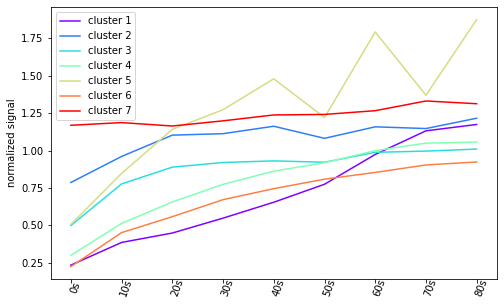

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

plotclustermeans(centers_BPM25, ncl)

In [19]:
# xls = MSC.clustermembers(E1020100.T)
# create_download_link(xls, "PNAS_5Clusters_weight=2.5.csv")